In [3]:
from calcimetry.mongo_api import MongoInfo
from calcimetry.thumbnail_api import ThumbnailAPI
from PIL import Image
import matplotlib.pyplot as plt
import io
import random
import base64

# Load Dataset


random.seed(1)

mongo_info = MongoInfo(host='localhost', port=27010)
thumb_list = []
with ThumbnailAPI(mongo_info=mongo_info) as thumb_api:
    size = thumb_api.size()
    for i in range(2):
        idx = int(random.random()*size)
        thumb, val_1m = thumb_api.read(idx)
        thumb_list.append(thumb)
    #plt.imshow(thumb)
    


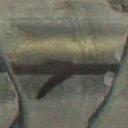
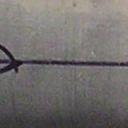

In [4]:
from IPython.display import Image, HTML, display

def to_base64(img: Image):
    byte_array = io.BytesIO()
    img.save(byte_array, format='jpeg')
    return base64.b64encode(byte_array.getvalue()).decode()

imagesList=''.join( ["<img style='width: 120px; margin: 0px; float: left; border: 1px solid black;' src='data:image/jpg;base64,%s' />"
     % to_base64(s) for s in thumb_list ])
display(HTML(imagesList))

